In [1]:
import faiss
import Levenshtein
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
from datasets import load_dataset, load_from_disk
from faiss import read_index, write_index
from matplotlib import pyplot as plt
from sentence_transformers import SentenceTransformer

sns.set()
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [7]:
df = pd.read_csv("../preprocessed/332_tfidf/000/data2.csv")
tfidf_prob = np.load("../output/350_1st_infer/tfidf/data2_pred.npy")
max_prob = np.load("../output/600_max/111/data2_pred.npy")

ignore_index = [201, 205, 207, 213, 217, 226, 228, 251, 254, 260, 262, 270, 286, 296, 308, 312, 338, 417]

num = 400
df = df.drop(ignore_index).head(num).reset_index(drop=True)
tfidf_prob = np.delete(tfidf_prob, ignore_index, axis=0)[:num]
max_prob = np.delete(max_prob, ignore_index, axis=0)[:num]

In [34]:
import Levenshtein
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.auto import tqdm

stop_words = list(stopwords.words("english"))


def get_tfidf(row: dict[str, str]) -> np.ndarray:
    """
    tfidfを計算する。大きめのngramにすることでうまく計算できるようにする
    """
    # tfidfの計算
    tfidf = TfidfVectorizer(
        ngram_range=(3, 7),
        # token_pattern=r"(?u)\b[\w/.-]+\b|!|/|\?|\"|\'",
        stop_words=stop_words,
    )
    base_cols = ["A", "B", "C", "D", "E"]
    fit_cols = base_cols + ["context", "prompt"]
    tfidf_vec = tfidf.fit([row[col] for col in fit_cols])
    # base_cols と context の 類似度を計算
    base_vec = tfidf_vec.transform([row[col] for col in base_cols])
    context_vec = tfidf_vec.transform([row["context"]])
    sim = cosine_similarity(base_vec, context_vec)
    return sim


def add_feat_by_prob(df, max_prob):
    first_prob = np.sort(max_prob)[:, -1]
    second_prob = np.sort(max_prob)[:, -2]
    third_prob = np.sort(max_prob)[:, -3]
    prob_diff = first_prob - second_prob
    df["first_prob"] = first_prob
    df["second_prob"] = second_prob
    df["third_prob"] = third_prob
    df["prob_diff"] = prob_diff
    df["prob_diff23"] = second_prob - third_prob

    option_to_index = {option: idx for idx, option in enumerate("ABCDE")}
    index_to_option = {v: k for k, v in option_to_index.items()}
    first_option = np.argsort(max_prob)[:, -1]
    df["first_option_index"] = first_option
    df["first_option"] = df["first_option_index"].map(index_to_option)
    second_option = np.argsort(max_prob)[:, -2]
    df["second_option_index"] = second_option
    df["second_option"] = df["second_option_index"].map(index_to_option)
    third_option = np.argsort(max_prob)[:, -3]
    df["third_option_index"] = third_option
    df["third_option"] = df["third_option_index"].map(index_to_option)

    df["first_len"] = 0
    df["second_len"] = 0
    df["third_len"] = 0
    for i, row in df.iterrows():
        df.loc[i, "first_len"] = len(row[row["first_option"]])
        df.loc[i, "second_len"] = len(row[row["second_option"]])
        df.loc[i, "third_len"] = len(row[row["third_option"]])

    # first と second のレーベンシュタイン距離
    dists = []
    for i, row in tqdm(df.iterrows()):
        dists.append(Levenshtein.distance(row[row["first_option"]], row[row["second_option"]]))
    df["dist_1_2"] = dists
    df["dist_1_2_rate"] = df["dist_1_2"] / df[["first_len", "second_len"]].max(axis=1)

    dists = []
    for i, row in tqdm(df.iterrows()):
        dists.append(Levenshtein.distance(row[row["first_option"]], row[row["third_option"]]))
    df["dist_1_3"] = dists
    df["dist_1_3_rate"] = df["dist_1_3"] / df[["first_len", "third_len"]].max(axis=1)

    # 正解がfirst, second, other のどれかを見る
    df["answer_location"] = "other"
    df.loc[df["first_option"] == df["answer"], "answer_location"] = "first"
    df.loc[df["second_option"] == df["answer"], "answer_location"] = "second"
    df.loc[df["third_option"] == df["answer"], "answer_location"] = "third"

    print("tfidfを計算")
    tfidf_array = []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        tfidf_array.append(get_tfidf(row).squeeze())
    tfidf_array = np.array(tfidf_array)
    print(f"tfidf_array:{tfidf_array.shape}")

    df["first_tfidf"] = tfidf_array[np.arange(len(df)), first_option]
    df["second_tfidf"] = tfidf_array[np.arange(len(df)), second_option]
    df["third_tfidf"] = tfidf_array[np.arange(len(df)), third_option]
    df["should_swap"] = (
        (df["prob_diff"] < 0.2)
        & (df["dist_1_2_rate"] < 0.2)
        & (20 < df["first_len"])
        & (0.001 < df["first_tfidf"])
        & (df["first_tfidf"] < df["second_tfidf"])
    )
    return df


df = add_feat_by_prob(df, max_prob)

df.head()

0it [00:00, ?it/s]

0it [00:00, ?it/s]

tfidfを計算


  0%|          | 0/400 [00:00<?, ?it/s]

tfidf_array:(400, 5)


,prompt,A,B,C,D,E,answer,context,first_prob,second_prob,...,third_len,dist_1_2,dist_1_2_rate,answer_location,first_tfidf,second_tfidf,should_swap,dist_1_3,dist_1_3_rate,third_tfidf
0,Which of the following statements accurately d...,MOND is a theory that reduces the observed mis...,MOND is a theory that increases the discrepanc...,MOND is a theory that explains the missing bar...,MOND is a theory that reduces the discrepancy ...,MOND is a theory that eliminates the observed ...,D,Modified Newtonian dynamics > Modified Newtoni...,0.999922,0.068841,...,192,7,0.035176,first,0.004991,0.004717,False,106,0.540816,0.001516
1,Which of the following is an accurate definiti...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,A,Dynamic scaling > Dynamic scaling > Here the e...,0.905612,0.209489,...,282,13,0.045614,first,0.005998,0.009001,False,31,0.108772,0.005883
2,Which of the following statements accurately d...,The triskeles symbol was reconstructed as a fe...,The triskeles symbol is a representation of th...,The triskeles symbol is a representation of a ...,The triskeles symbol represents three interloc...,The triskeles symbol is a representation of th...,A,Triskelion > Use in European antiquity > Class...,0.811835,0.768880,...,367,203,0.602374,first,0.004281,0.001612,False,191,0.520436,0.004505
3,What is the significance of regularization in ...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,C,Regularization (physics) > Classical physics e...,0.944936,0.373496,...,219,144,0.555985,first,0.001364,0.005692,False,88,0.339768,0.000000
4,Which of the following statements accurately d...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,D,Diffraction > Patterns > Several qualitative o...,0.997662,0.540189,...,241,11,0.045267,first,0.122631,0.018601,False,12,0.049793,0.019278


In [35]:
df[df["answer_location"] != "first"]

,prompt,A,B,C,D,E,answer,context,first_prob,second_prob,...,third_len,dist_1_2,dist_1_2_rate,answer_location,first_tfidf,second_tfidf,should_swap,dist_1_3,dist_1_3_rate,third_tfidf
13,What is the Roche limit?,The Roche limit is the distance at which tidal...,The Roche limit is the distance at which tidal...,The Roche limit is the distance at which tidal...,The Roche limit is the distance at which tidal...,The Roche limit is the distance at which tidal...,D,Roche limit > Roche limit > In celestial mecha...,0.947438,0.834348,...,160,139,0.460265,second,0.012845,0.022513,False,172,0.569536,0.003466
28,What is the evidence for the existence of a su...,The Milky Way galaxy has a supermassive black ...,The Milky Way galaxy has a supermassive black ...,The Milky Way galaxy has a supermassive black ...,The Milky Way galaxy has a supermassive black ...,The star S2 follows an elliptical orbit with a...,E,Supermassive black hole > Evidence > From the ...,0.740287,0.553895,...,242,81,0.122356,second,0.080636,0.131271,True,472,0.712991,0.060301
39,What is the synapstor or synapse transistor?,A device used to demonstrate a neuro-inspired ...,A device used to demonstrate a neuro-inspired ...,A device used to demonstrate a neuro-inspired ...,A device used to demonstrate a neuro-inspired ...,A device used to demonstrate a neuro-inspired ...,E,"Memristor > Implementations > In July 2008, Er...",0.457426,0.410623,...,132,4,0.029851,second,0.007564,0.011028,True,2,0.014925,0.006071
65,What is the relevant type of coherence for the...,Visibility,Coherence time,Spatial coherence,Coherence length,Diameter of the coherence area (Ac),E,Coherence (physics) > Spatial coherence > In s...,0.999891,0.248822,...,14,23,0.657143,second,0.000000,0.025767,False,14,0.823529,0.000000
238,What is the significance of HD 208487?,HD 208487 is a star with the same spectral typ...,HD 208487 is a 7th-magnitude G-type main-seque...,HD 208487 is a star named Itonda.,HD 208487 is a star that has one known extraso...,HD 208487 is a star that is 144 light-years aw...,D,Doppler spectroscopy > Procedure > The method ...,0.963451,0.848666,...,85,109,0.694268,third,0.001631,0.039804,False,102,0.649682,0.000000
249,What is the function of R1162-like plasmid ant...,Negatively regulates the RepI region of the pl...,Negatively regulates the RepI region of the pl...,Decreases the expression of the protein produc...,Positively regulates the RepI region of the pl...,Increases the expression of the protein produc...,A,R1162-like plasmid antisense RNA > R1162-like ...,0.966449,0.327922,...,109,2,0.020833,second,0.020918,0.022231,False,64,0.587156,0.011245
266,"What is the etymology of the name ""Aggregatiba...","The name ""Aggregatibacter"" is derived from the...","The name ""Aggregatibacter"" is derived from the...","The name ""Aggregatibacter"" is derived from the...","The name ""Aggregatibacter"" is derived from the...","The name ""Aggregatibacter"" is derived from the...",B,Pseudonym > Etymology > The term pseudonym is ...,0.328632,0.326631,...,130,43,0.307143,other,0.002467,0.002441,False,22,0.169231,0.002467
272,What are laminaria sticks commonly made from?,Laminaria japonica,Laminaria digitata,Dilapan,Synthetic materials,Dried kelp stems,E,Drum kit > Playing > Grip Most drummers hold t...,0.852585,0.824749,...,18,16,0.888889,second,0.000000,0.000000,False,7,0.388889,0.000000
298,Who initially labeled the heavily obscured glo...,The Milky Way's center,French astronomer Agop Terzan,Terzan 11,The Two-Micron Sky Survey,IRC–20385,C,Djorgovski 1 > Djorgovski 1 > Djorgovski 1 is ...,0.994185,0.258549,...,26,24,0.827586,second,0.000000,0.000000,False,24,0.827586,0.000000
330,Which regular polygons are known to be constru...,Regular hexagons,Regular decagons,Regular triangles,Regular heptagons,Regular octagons,E,Straightedge and compass construction > Constr...,0.918718,0.231284,...,16,6,0.352941,second,0.000000,0.000000,False,6,0.352941,0.000000


<Axes: xlabel='prob_diff', ylabel='Count'>

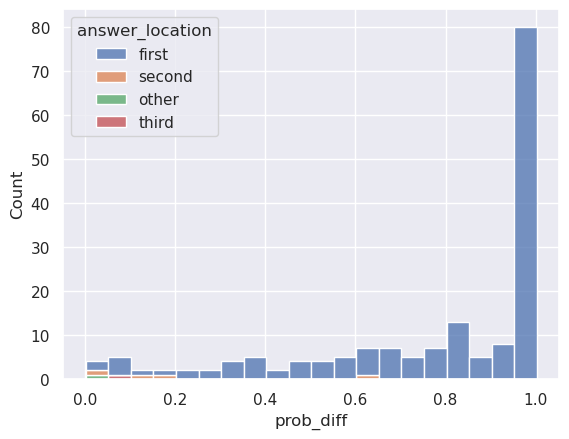

In [40]:
condition = (0.001 < df["first_tfidf"]) & (df["dist_1_2_rate"] < 0.5) & (20 < df["first_len"])


tmp_df = df.loc[condition]
sns.histplot(data=tmp_df, x="prob_diff", hue="answer_location", multiple="stack", binwidth=0.05)

In [51]:
df[
    (df["prob_diff"] < 0.2)
    & (df["dist_1_2_rate"] < 0.5)
    & (20 < df["first_len"])
    & ((0.01 < df["first_tfidf"]) | (0.01 < df["second_tfidf"]))
    & (df["second_tfidf"] / (df["first_tfidf"] + 1e-9) > 1.2)
]

,prompt,A,B,C,D,E,answer,context,first_prob,second_prob,...,third_len,dist_1_2,dist_1_2_rate,answer_location,first_tfidf,second_tfidf,should_swap,dist_1_3,dist_1_3_rate,third_tfidf
13,What is the Roche limit?,The Roche limit is the distance at which tidal...,The Roche limit is the distance at which tidal...,The Roche limit is the distance at which tidal...,The Roche limit is the distance at which tidal...,The Roche limit is the distance at which tidal...,D,Roche limit > Roche limit > In celestial mecha...,0.947438,0.834348,...,160,139,0.460265,second,0.012845,0.022513,False,172,0.569536,0.003466
28,What is the evidence for the existence of a su...,The Milky Way galaxy has a supermassive black ...,The Milky Way galaxy has a supermassive black ...,The Milky Way galaxy has a supermassive black ...,The Milky Way galaxy has a supermassive black ...,The star S2 follows an elliptical orbit with a...,E,Supermassive black hole > Evidence > From the ...,0.740287,0.553895,...,242,81,0.122356,second,0.080636,0.131271,True,472,0.712991,0.060301
39,What is the synapstor or synapse transistor?,A device used to demonstrate a neuro-inspired ...,A device used to demonstrate a neuro-inspired ...,A device used to demonstrate a neuro-inspired ...,A device used to demonstrate a neuro-inspired ...,A device used to demonstrate a neuro-inspired ...,E,"Memristor > Implementations > In July 2008, Er...",0.457426,0.410623,...,132,4,0.029851,second,0.007564,0.011028,True,2,0.014925,0.006071


In [50]:
df[
    (df["second_prob"] > 0.4)
    & (df["dist_1_2_rate"] < 0.5)
    & (20 < df["first_len"])
    & ((0.01 < df["first_tfidf"]) | (0.01 < df["second_tfidf"]))
    & (df["second_tfidf"] / (df["first_tfidf"] + 1e-9) > 1.4)
]

,prompt,A,B,C,D,E,answer,context,first_prob,second_prob,...,third_len,dist_1_2,dist_1_2_rate,answer_location,first_tfidf,second_tfidf,should_swap,dist_1_3,dist_1_3_rate,third_tfidf
7,Which of the following statements accurately d...,The blocking temperature of an antiferromagnet...,The blocking temperature of an antiferromagnet...,The blocking temperature of an antiferromagnet...,The blocking temperature of an antiferromagnet...,The blocking temperature of an antiferromagnet...,D,Antiferromagnetism > Antiferromagnetic materia...,0.999612,0.476940,...,289,51,0.186131,first,0.003286,0.036598,False,65,0.224913,0.018249
13,What is the Roche limit?,The Roche limit is the distance at which tidal...,The Roche limit is the distance at which tidal...,The Roche limit is the distance at which tidal...,The Roche limit is the distance at which tidal...,The Roche limit is the distance at which tidal...,D,Roche limit > Roche limit > In celestial mecha...,0.947438,0.834348,...,160,139,0.460265,second,0.012845,0.022513,False,172,0.569536,0.003466
28,What is the evidence for the existence of a su...,The Milky Way galaxy has a supermassive black ...,The Milky Way galaxy has a supermassive black ...,The Milky Way galaxy has a supermassive black ...,The Milky Way galaxy has a supermassive black ...,The star S2 follows an elliptical orbit with a...,E,Supermassive black hole > Evidence > From the ...,0.740287,0.553895,...,242,81,0.122356,second,0.080636,0.131271,True,472,0.712991,0.060301
39,What is the synapstor or synapse transistor?,A device used to demonstrate a neuro-inspired ...,A device used to demonstrate a neuro-inspired ...,A device used to demonstrate a neuro-inspired ...,A device used to demonstrate a neuro-inspired ...,A device used to demonstrate a neuro-inspired ...,E,"Memristor > Implementations > In July 2008, Er...",0.457426,0.410623,...,132,4,0.029851,second,0.007564,0.011028,True,2,0.014925,0.006071
219,What are fenamates?,Organic compounds derived from anthranilic aci...,Organic compounds derived from 2-chlorobenzoic...,Organic compounds derived from acridone that s...,Organic compounds derived from 2-chlorobenzofu...,Organic compounds derived from fenamic acid th...,A,Fenamic acid > Fenamic acid > Fenamic acid is ...,0.847758,0.546900,...,95,63,0.488372,first,0.014271,0.027533,False,72,0.558140,0.001098


In [87]:
df["second_option_index"]

0       1
1       1
2       3
3       0
4       0
       ..
1195    3
1196    1
1197    2
1198    2
1199    4
Name: second_option_index, Length: 1200, dtype: int64

In [90]:
max_prob[df["should_swap"], df.loc[df["should_swap"], "second_option_index"]] = (
    max_prob[df["should_swap"], df.loc[df["should_swap"], "first_option_index"]] + 1.0
)

In [79]:
df.iloc[447]

prompt             Which of the following statements accurately d...
A                  Bis-gamma-glutamylcystine reductase acts on ga...
B                  Bis-gamma-glutamylcystine reductase acts on ga...
C                  Bis-gamma-glutamylcystine reductase acts on ga...
D                  Bis-gamma-glutamylcystine reductase acts on bi...
E                  Bis-gamma-glutamylcystine reductase acts on ga...
answer                                                             C
context            Bis-gamma-glutamylcystine reductase > Bis-gamm...
first_prob                                                  0.660314
second_prob                                                 0.475209
third_prob                                                  0.131103
prob_diff                                                   0.185105
prob_diff23                                                 0.344106
first_option                                                       C
second_option                     

In [65]:
df.iloc[179].C

"The difference in distance travelled by light from the planet (or its moon) to Earth when the Earth is at the point in its orbit that is closest to its planet than when the Earth is at the farthest point in its orbit, the difference in distance being the diameter of the Earth's orbit around the Sun."

In [66]:
df.iloc[179].E

"The difference in the gravitational pull of the planet on its moons when the Earth is at the point in its orbit that is closest to its planet than when the Earth is at the farthest point in its orbit, the difference in distance being the diameter of the Earth's orbit around the Sun."

In [67]:
df.iloc[179].context

'Speed of light > Measurement > Ole Christensen Rømer used an astronomical measurement to make the first quantitative estimate of the speed of light in the year 1676. When measured from Earth, the periods of moons orbiting a distant planet are shorter when the Earth is approaching the planet than when the Earth is receding from it. The distance travelled by light from the planet (or its moon) to Earth is shorter when the Earth is at the point in its orbit that is closest to its planet than when the Earth is at the farthest point in its orbit, the difference in distance being the diameter of the Earth\'s orbit around the Sun. The observed change in the moon\'s orbital period is caused by the difference in the time it takes light to traverse the shorter or longer distance. Rømer observed this effect for Jupiter\'s innermost major moon Io and deduced that light takes 22 minutes to cross the diameter of the Earth\'s orbit. Libration point orbit > Libration point orbit > In orbital mechanic